In [13]:
import csv
import numpy as np
import unicodedata
import re
import difflib
import gliner2
import shelve
import scipy.stats
import tqdm
import sentence_transformers

import backend.similarity
import backend.extractors

In [26]:
data = list(csv.DictReader(open("../data/addresses.csv", encoding="UTF-8-SIG")))
data = [{k: unicodedata.normalize('NFD', v) if isinstance(v, str) else v for k, v in record.items()} for record in data]

def evaluate(similarity_fn, sample=None, random_seed=42, n_errors=None):
    evaluation_data = data
    if sample is not None and 0 < sample < 1:
        np.random.seed(random_seed)
        n_samples = max(1, int(len(data) * sample))
        indices = np.random.choice(len(data), size=n_samples, replace=False)
        evaluation_data = [data[i] for i in indices]
        print(f"Sampling {len(evaluation_data)} out of {len(data)} records ({sample*100:.1f}%)")

    actual_similarity = np.array([float(record["semantic_similarity"]) for record in evaluation_data], dtype=np.float64)
    predicted_similarity = np.array([
        similarity_fn(record["address"], record["matched_address"]) 
        for record in tqdm.tqdm(evaluation_data, desc="Evaluating")
    ], dtype=np.float64)

    # Ensure predictions are in valid range [0, 1]
    predicted_similarity = np.clip(predicted_similarity, 0.0, 1.0)

    # Spearman correlation (ranking metric)
    spearman_result = scipy.stats.spearmanr(actual_similarity, predicted_similarity)
    spearman_corr = spearman_result.correlation
    spearman_pvalue = spearman_result.pvalue

    # KL-divergence (per-pair distribution matching)
    # Create 2-element distributions: [1-similarity, similarity] for each pair
    eps = 1e-10  # Small epsilon to avoid log(0)
    actual_dist = np.column_stack([1 - actual_similarity, actual_similarity]) + eps
    predicted_dist = np.column_stack([1 - predicted_similarity, predicted_similarity]) + eps

    # Normalize to probabilities (sum to 1)
    actual_dist = actual_dist / actual_dist.sum(axis=1, keepdims=True)
    predicted_dist = predicted_dist / predicted_dist.sum(axis=1, keepdims=True)

    # Compute KL divergence per pair, then average
    kl_divergence = scipy.stats.entropy(actual_dist.T, predicted_dist.T, axis=0).mean()

    # MAE (magnitude accuracy)
    abs_errors = np.abs(actual_similarity - predicted_similarity)
    mae = float(np.mean(abs_errors))

    result = {
        "spearman_correlation": spearman_corr,
        "spearman_pvalue": spearman_pvalue,
        "kl_divergence": kl_divergence,
        "mae": mae,
        "mean_actual": float(np.mean(actual_similarity)),
        "mean_predicted": float(np.mean(predicted_similarity)),
    }

    if n_errors is not None:
        n = int(n_errors)
        if n <= 0:
            result["worst_errors"] = []
        else:
            n = min(n, len(evaluation_data))
            worst_idx = np.argsort(abs_errors)[-n:][::-1]
            parse_fn = getattr(similarity_fn, "_parse", None)
            can_parse = callable(parse_fn)

            result["worst_errors"] = [
                {
                    "rank": int(rank + 1),
                    "abs_error": float(abs_errors[i]),
                    "actual": float(actual_similarity[i]),
                    "predicted": float(predicted_similarity[i]),
                    "address": evaluation_data[i]["address"],
                    "address_data": (parse_fn(evaluation_data[i]["address"]) if can_parse else None),
                    "matched_address": evaluation_data[i]["matched_address"],
                    "matched_address_data": (parse_fn(evaluation_data[i]["matched_address"]) if can_parse else None),
                }
                for rank, i in enumerate(worst_idx)
            ]

    return result

In [ ]:
baseline = backend.similarity.BaselineAddressSimilarity()
evaluate(baseline.score)

Evaluating: 100%|██████████████████████████████████████████████████| 500/500 [00:00<00:00, 23063.62it/s]


{'spearman_correlation': np.float64(0.6775270997784685),
 'spearman_pvalue': np.float64(1.8997320629143054e-68),
 'kl_divergence': np.float64(0.20827045410717795),
 'mae': 0.20805784013181053,
 'mean_actual': 0.87634,
 'mean_predicted': 0.6993311177501039}

In [ ]:
class SentenceTransformerSimilarity:
    def __init__(self, model_name: str = "sentence-transformers/all-MiniLM-L6-v2"):
        self.model = sentence_transformers.SentenceTransformer(model_name)

    def score(self, a: str, b: str) -> float:
        if not a or not b:
            return 0.0

        va, vb = self.model.encode([a, b], normalize_embeddings=True)
        sim = float(np.dot(va, vb))
        return float(np.clip((sim + 1.0) / 2.0, 0.0, 1.0))


st_similarity = SentenceTransformerSimilarity()
evaluate(st_similarity.score)

Evaluating: 100%|█████████████████████████████████████████████████████| 500/500 [00:05<00:00, 90.08it/s]


{'spearman_correlation': np.float64(0.5477209827020497),
 'spearman_pvalue': np.float64(1.7467178014940477e-40),
 'kl_divergence': np.float64(0.08948095412865585),
 'mae': 0.0965299331754446,
 'mean_actual': 0.87634,
 'mean_predicted': 0.9006953294724226}

Scoring embeddings: 100%|████████████████████████████████████████████| 500/500 [00:04<00:00, 100.95it/s]


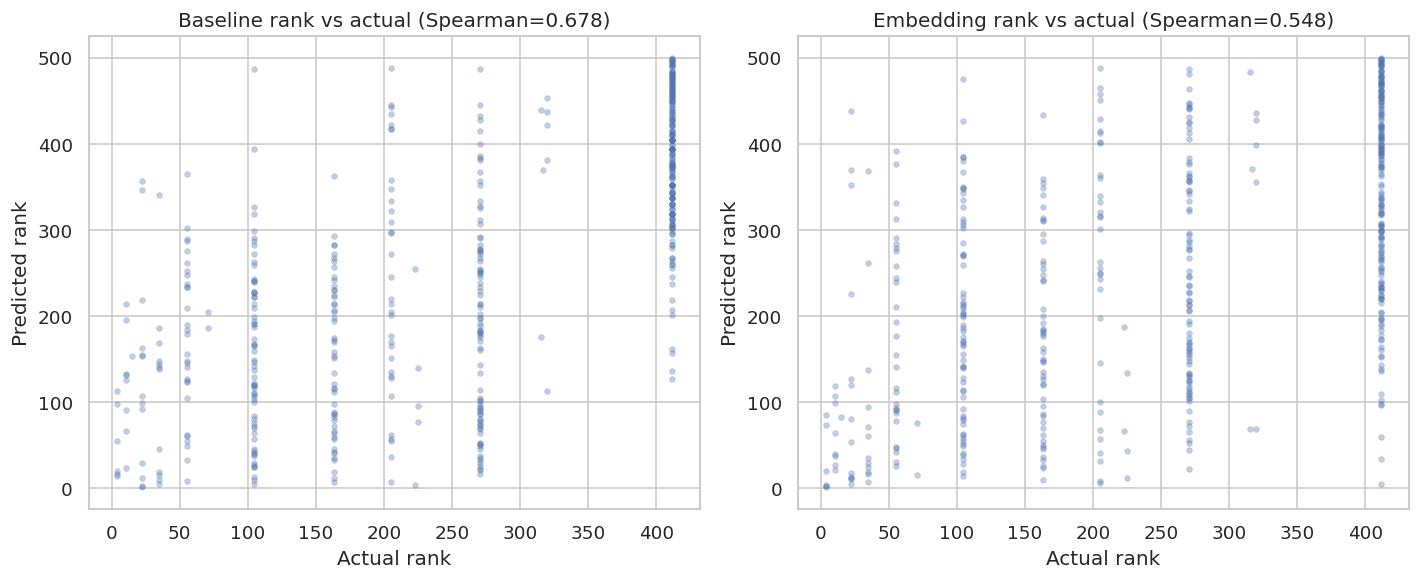

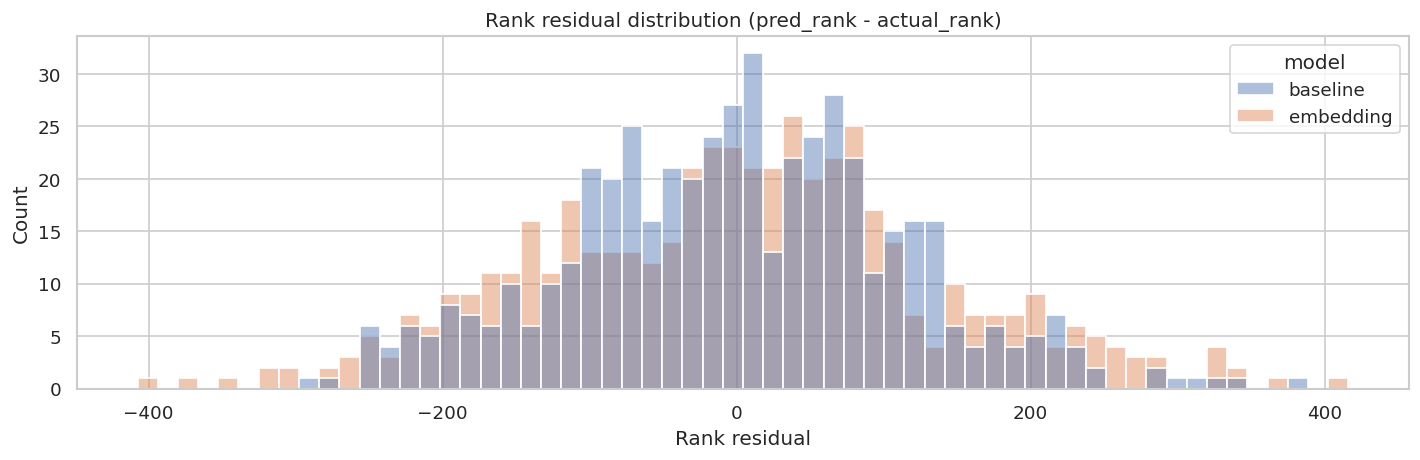

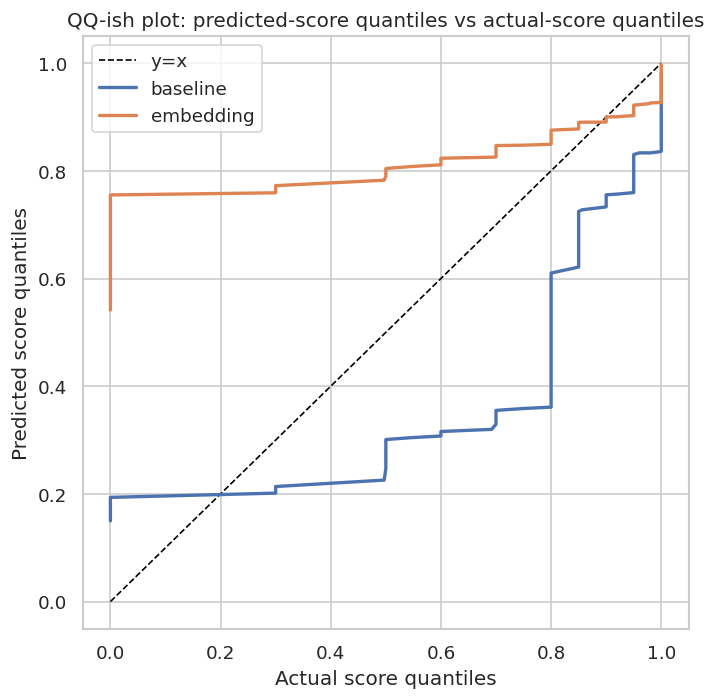

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style="whitegrid")

actual = np.array([float(r["semantic_similarity"]) for r in data], dtype=np.float64)

baseline = backend.similarity.BaselineAddressSimilarity()

pred_baseline = np.array([
    baseline.score(r["address"], r["matched_address"])
    for r in tqdm.tqdm(data, desc="Scoring baseline")
], dtype=np.float64)

pred_embed = np.array([
    st_similarity.score(r["address"], r["matched_address"])
    for r in tqdm.tqdm(data, desc="Scoring embeddings")
], dtype=np.float64)

r_actual = scipy.stats.rankdata(actual, method="average")
r_base = scipy.stats.rankdata(pred_baseline, method="average")
r_embed = scipy.stats.rankdata(pred_embed, method="average")

df = pd.DataFrame(
    {
        "r_actual": r_actual,
        "r_baseline": r_base,
        "r_embed": r_embed,
        "baseline_resid": r_base - r_actual,
        "embed_resid": r_embed - r_actual,
        "actual": actual,
        "pred_baseline": pred_baseline,
        "pred_embed": pred_embed,
    }
)

# Rank-vs-rank scatter (seaborn)
fig, ax = plt.subplots(1, 2, figsize=(12, 5), dpi=120)

sns.scatterplot(data=df, x="r_actual", y="r_baseline", s=12, alpha=0.35, ax=ax[0], edgecolor=None)
ax[0].set_title(f"Baseline rank vs actual (Spearman={scipy.stats.spearmanr(actual, pred_baseline).correlation:.3f})")
ax[0].set_xlabel("Actual rank")
ax[0].set_ylabel("Predicted rank")

sns.scatterplot(data=df, x="r_actual", y="r_embed", s=12, alpha=0.35, ax=ax[1], edgecolor=None)
ax[1].set_title(f"Embedding rank vs actual (Spearman={scipy.stats.spearmanr(actual, pred_embed).correlation:.3f})")
ax[1].set_xlabel("Actual rank")
ax[1].set_ylabel("Predicted rank")

plt.tight_layout()
plt.show()

# Rank residual distribution
resid_long = pd.DataFrame(
    {
        "residual": np.concatenate([df["baseline_resid"].to_numpy(), df["embed_resid"].to_numpy()]),
        "model": ["baseline"] * len(df) + ["embedding"] * len(df),
    }
)

plt.figure(figsize=(12, 4), dpi=120)
sns.histplot(data=resid_long, x="residual", hue="model", bins=60, stat="count", common_norm=False, alpha=0.45)
plt.title("Rank residual distribution (pred_rank - actual_rank)")
plt.xlabel("Rank residual")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

# QQ-ish: quantiles of predicted scores vs quantiles of actual scores
qs = np.linspace(0.0, 1.0, 201)
q_actual = np.quantile(actual, qs)
q_base = np.quantile(pred_baseline, qs)
q_embed = np.quantile(pred_embed, qs)

plt.figure(figsize=(6, 6), dpi=120)
plt.plot(q_actual, q_actual, linestyle="--", linewidth=1, color="black", label="y=x")
plt.plot(q_actual, q_base, linewidth=2, label="baseline")
plt.plot(q_actual, q_embed, linewidth=2, label="embedding")
plt.title("QQ-ish plot: predicted-score quantiles vs actual-score quantiles")
plt.xlabel("Actual score quantiles")
plt.ylabel("Predicted score quantiles")
plt.legend()
plt.tight_layout()
plt.show()



In [ ]:
class AddressSimilarityWithExtraction:
    def __init__(self, number_weight: float = 0.4):
        self.number_weight = number_weight

    def _normalize(self, text: str) -> str:
        return " ".join(text.strip().lower().split())

    def _extract_numbers(self, text: str):
        numbers = re.findall(r"\d+(?:\.\d+)?", text)
        text_without_numbers = re.sub(r"\d+(?:\.\d+)?", "", text)
        return text_without_numbers, numbers

    def _compare_numbers(self, numbers_a: list, numbers_b: list) -> float:
        if not numbers_a and not numbers_b:
            return 1.0
        if not numbers_a or not numbers_b:
            return 0.0

        set_a = set(numbers_a)
        set_b = set(numbers_b)
        intersection = len(set_a & set_b)
        union = len(set_a | set_b)

        if union == 0:
            return 1.0

        return intersection / union

    def _parse(self, address: str) -> dict:
        """Parse address into components.

        Returns a dict with keys: country, postal_code, house_number, rest.
        Each value is stripped of leading/trailing commas/spaces (or None).
        """
        rest, country = backend.extractors.extract_country(address)
        text_wo_numbers, numbers = self._extract_numbers(rest)

        postal_code = None
        house_number = None

        # Heuristic extraction from number tokens (keeps old behavior but exposes components)
        # Postal code: last numeric token with 4+ digits
        long_nums = [n for n in numbers if re.fullmatch(r"\d{4,}", n or "")]
        if long_nums:
            postal_code = long_nums[-1]

        # House number: last numeric token with 1-3 digits
        short_nums = [n for n in numbers if re.fullmatch(r"\d{1,3}", n or "")]
        if short_nums:
            house_number = short_nums[-1]

        def _strip_part(x):
            if x is None:
                return None
            x = str(x).strip(" ,")
            return x or None

        rest_clean = re.sub(r"\s+", " ", text_wo_numbers).strip(" ,")
        return {
            "country": _strip_part(country),
            "postal_code": _strip_part(postal_code),
            "house_number": _strip_part(house_number),
            "rest": rest_clean,
        }

    def __call__(self, a: str, b: str) -> float:
        if not a or not b:
            return 0.0

        parsed_a = self._parse(a)
        parsed_b = self._parse(b)
        country_a, rest_a = parsed_a["country"], parsed_a["rest"]
        country_b, rest_b = parsed_b["country"], parsed_b["rest"]

        # keep original numeric similarity (all number tokens, not just house/postal)
        text_a, numbers_a = self._extract_numbers(backend.extractors.extract_country(a)[0])
        text_b, numbers_b = self._extract_numbers(backend.extractors.extract_country(b)[0])
        number_similarity = self._compare_numbers(numbers_a, numbers_b)

        normalized_a = self._normalize(rest_a)
        normalized_b = self._normalize(rest_b)

        if not normalized_a or not normalized_b:
            if not normalized_a and not normalized_b:
                country_match = 1.0 if country_a == country_b else 0.0
                return self.number_weight * number_similarity + (1 - self.number_weight) * country_match
            return self.number_weight * number_similarity

        text_similarity = difflib.SequenceMatcher(None, normalized_a, normalized_b).ratio()

        combined_similarity = (self.number_weight * number_similarity) + ((1 - self.number_weight) * text_similarity)

        return combined_similarity


address_similarity_with_extraction = AddressSimilarityWithExtraction(number_weight=0.4)
evaluate(address_similarity_with_extraction, n_errors=100)

Evaluating: 100%|██████████| 500/500 [00:00<00:00, 1997.77it/s]


{'spearman_correlation': np.float64(0.767335697415665),
 'spearman_pvalue': np.float64(3.6784922790515886e-98),
 'kl_divergence': np.float64(0.1845892131895476),
 'mae': 0.21027591567980847,
 'mean_actual': 0.87634,
 'mean_predicted': 0.6767404650787939,
 'worst_errors': [{'rank': 1,
   'abs_error': 0.71,
   'actual': 0.95,
   'predicted': 0.24,
   'address': 'Germany,Görlitz,2826',
   'address_data': {'country': 'Germany',
    'postal_code': '2826',
    'house_number': None,
    'rest': 'Görlitz'},
   'matched_address': 'Görlitz, Kreis Görlitz, Saxony, Germany',
   'matched_address_data': {'country': 'Germany',
    'postal_code': None,
    'house_number': None,
    'rest': 'Görlitz, Kreis Görlitz, Saxony'}},
  {'rank': 2,
   'abs_error': 0.6564516129032258,
   'actual': 0.85,
   'predicted': 0.1935483870967742,
   'address': 'Germany,Bad honnef,53604',
   'address_data': {'country': 'Germany',
    'postal_code': '53604',
    'house_number': None,
    'rest': 'Bad honnef'},
   'm

In [ ]:
class AddressSimilarityWithPostalCodeHandling:
    """
    Same idea as AddressSimilarityWithExtraction, but:
    - Postal code: last numeric token with 4+ digits (digits only)
    - House number: last numeric token with 1-3 digits, optionally followed by a single letter (e.g. 29a, 29 a)

    Both extracted tokens are removed from the text before computing text similarity.
    """

    def __init__(self, postal_weight: float = 0.35, house_weight: float = 0.25):
        if postal_weight < 0 or house_weight < 0 or (postal_weight + house_weight) > 1:
            raise ValueError("postal_weight and house_weight must be >= 0 and sum to <= 1")
        self.postal_weight = postal_weight
        self.house_weight = house_weight

    def _normalize(self, text: str) -> str:
        return " ".join(text.strip().lower().split())

    # Postal/house extraction moved to backend.extractors

    def _compare_optional(self, a: str | None, b: str | None) -> float:
        if a is None and b is None:
            return 1.0
        if a is None or b is None:
            return 0.0
        return 1.0 if a == b else 0.0

    def _parse(self, address: str) -> dict:
        """Parse address into components.

        Returns a dict with keys: country, postal_code, house_number, rest.
        Each value is stripped of leading/trailing commas/spaces (or None).
        """
        rest, country = backend.extractors.extract_country(address)

        # Extract postal first, then house number, using shared extractors
        text, postal_code = backend.extractors.extract_postal_code(rest)
        text, house_number = backend.extractors.extract_house_number(text)

        def _strip_part(x):
            if x is None:
                return None
            x = str(x).strip(" ,")
            return x or None

        rest_clean = re.sub(r"\s+", " ", text).strip(" ,")
        return {
            "country": _strip_part(country),
            "postal_code": _strip_part(postal_code),
            "house_number": _strip_part(house_number),
            "rest": rest_clean,
        }

    def __call__(self, a: str, b: str) -> float:
        if not a or not b:
            return 0.0

        parsed_a = self._parse(a)
        parsed_b = self._parse(b)
        country_a, postal_a, house_a, rest_a = (
            parsed_a["country"],
            parsed_a["postal_code"],
            parsed_a["house_number"],
            parsed_a["rest"],
        )
        country_b, postal_b, house_b, rest_b = (
            parsed_b["country"],
            parsed_b["postal_code"],
            parsed_b["house_number"],
            parsed_b["rest"],
        )

        # --- normalize helpers ---
        def _norm_country(x: str | None) -> str | None:
            return x.strip(" ,").lower() if x else None

        def _norm_postal(x: str | None) -> str | None:
            if not x:
                return None
            # normalize: remove spaces/hyphens, uppercase
            return re.sub(r"[\s-]+", "", x).upper()

        def _norm_house(x: str | None) -> str | None:
            if not x:
                return None
            return re.sub(r"\s+", "", x).lower()

        ca, cb = _norm_country(country_a), _norm_country(country_b)
        pa, pb = _norm_postal(postal_a), _norm_postal(postal_b)
        ha, hb = _norm_house(house_a), _norm_house(house_b)

        country_known = (ca is not None) and (cb is not None)
        postal_known = (pa is not None) and (pb is not None)
        house_known = (ha is not None) and (hb is not None)

        country_match = (ca == cb) if country_known else None
        postal_match = (pa == pb) if postal_known else None
        house_match = (ha == hb) if house_known else None

        # --- rest similarity (robust-ish to ordering) ---
        norm_a = self._normalize(rest_a)
        norm_b = self._normalize(rest_b)

        if not norm_a or not norm_b:
            rest_sim = 1.0 if (not norm_a and not norm_b) else 0.0
        else:
            # plain similarity
            s1 = difflib.SequenceMatcher(None, norm_a, norm_b).ratio()
            # token-sorted similarity (order-invariant-ish)
            t1 = " ".join(sorted(norm_a.split()))
            t2 = " ".join(sorted(norm_b.split()))
            s2 = difflib.SequenceMatcher(None, t1, t2).ratio()
            rest_sim = max(s1, s2)

        # --- gated scoring ---
        base = 0.0
        max_score = 1.0

        # Country gate: if both known and different, cap hard
        if country_known and country_match is False:
            max_score = min(max_score, 0.25)

        # Postal code: strongest signal
        if postal_known and postal_match is True:
            base = max(base, 0.85)
        elif postal_known and postal_match is False:
            max_score = min(max_score, 0.55)

        # House number: strong only if rest is strong
        if house_known and house_match is True and rest_sim > 0.80:
            base = max(base, 0.92)
        elif house_known and house_match is False and rest_sim > 0.80:
            max_score = min(max_score, 0.85)

        # ensure band is sane
        if max_score < base:
            max_score = base

        score = base + (max_score - base) * rest_sim
        return float(np.clip(score, 0.0, 1.0))


address_similarity_with_postal_handling = AddressSimilarityWithPostalCodeHandling(postal_weight=0.35, house_weight=0.25)
evaluate(address_similarity_with_postal_handling, n_errors=3)


Evaluating:   0%|          | 0/500 [00:00<?, ?it/s]

Evaluating: 100%|██████████| 500/500 [00:00<00:00, 2981.22it/s]


{'spearman_correlation': np.float64(0.7375240353420878),
 'spearman_pvalue': np.float64(6.034981718739336e-87),
 'kl_divergence': np.float64(0.10801485278018831),
 'mae': 0.10022761552926929,
 'mean_actual': 0.87634,
 'mean_predicted': 0.8789816791133239,
 'worst_errors': [{'rank': 1,
   'abs_error': 0.6299999999999999,
   'actual': 0.3,
   'predicted': 0.9299999999999999,
   'address': 'calle Ali Bey 135local 1, 08013 Barcelona Spain',
   'address_data': {'country': 'Spain',
    'postal_code': '08013',
    'house_number': '1',
    'rest': 'calle Ali Bey 135local , Barcelona'},
   'matched_address': 'Carrer De Sardenya 289, 08013 Barcelona, Barcelona, Spain',
   'matched_address_data': {'country': 'Spain',
    'postal_code': '08013',
    'house_number': '289',
    'rest': 'Carrer De Sardenya , Barcelona, Barcelona'}},
  {'rank': 2,
   'abs_error': 0.6166666666666667,
   'actual': 0.3,
   'predicted': 0.9166666666666666,
   'address': '2 RUE DE LA CITE - IMMEUBLE DE LA CITE -, 75004 PAR

In [ ]:
address_similarity_with_postal_handling._parse("calle Ali Bey 135local 1, 08013 Barcelona Spain")

{'country': 'Spain',
 'postal_code': '08013',
 'house_number': '1',
 'rest': 'calle Ali Bey 135local , Barcelona'}

In [ ]:
address_similarity_with_postal_handling._parse("Carrer De Sardenya 289, 08013 Barcelona, Barcelona, Spain")

{'country': 'Spain',
 'postal_code': '08013',
 'house_number': '289',
 'rest': 'Carrer De Sardenya , Barcelona, Barcelona'}

In [5]:
class AddressSimilarityWithGLiNER:
    """Hybrid similarity:

    - Use `backend.extractors` for country / postal_code / house_number / rest.
    - Use GLiNER only for `street_name` and `city`.

    `_parse()` returns a dict including the unified extractor keys plus `street_name` and `city`.
    """

    def __init__(
        self,
        model_name: str = "fastino/gliner2-base-v1",
        street_weight: float = 0.35,
        city_weight: float = 0.25,
        postal_weight: float = 0.25,
        house_weight: float = 0.10,
        country_mismatch_cap: float = 0.25,
    ):
        self.model = gliner2.GLiNER2.from_pretrained(model_name)

        # Only the two semantic-ish fields go to GLiNER
        self.labels = {
            "city": {
                "description": "The city name, examples: Amsterdam, Rotterdam, The Hague",
                "dtype": "str",
            },
            "street_name": {
                "description": "The name of a street or a road of the address",
                "dtype": "str",
            },
        }

        self.street_weight = street_weight
        self.city_weight = city_weight
        self.postal_weight = postal_weight
        self.house_weight = house_weight
        self.country_mismatch_cap = country_mismatch_cap

        # simple in-memory cache (avoid shelve/dbm issues)
        self._cache: dict[str, dict] = {}

    def _normalize_text(self, text: str | None) -> str:
        if not text:
            return ""
        return " ".join(str(text).strip().lower().split())

    def _extract_entities(self, text: str) -> dict:
        if not text:
            return {"street_name": None, "city": None}
        if text in self._cache:
            return self._cache[text]

        out = self.model.extract_entities(text, self.labels)
        ents = out.get("entities", {}) if isinstance(out, dict) else {}

        def _get_first(label: str) -> str | None:
            v = ents.get(label)
            if not v:
                return None
            return str(v).strip(" ,") or None

        result = {
            "street_name": _get_first("street_name"),
            "city": _get_first("city"),
        }
        self._cache[text] = result
        return result

    def _parse(self, address: str) -> dict:
        base = backend.extractors.parse_address_components(address)
        ents = self._extract_entities(base["rest"])
        base["street_name"] = ents.get("street_name")
        base["city"] = ents.get("city")
        return base

    def _sim(self, a: str | None, b: str | None) -> float:
        na = self._normalize_text(a)
        nb = self._normalize_text(b)
        if not na and not nb:
            return 1.0
        if not na or not nb:
            return 0.0
        return difflib.SequenceMatcher(None, na, nb).ratio()

    def __call__(self, a: str, b: str) -> float:
        if not a or not b:
            return 0.0

        pa = self._parse(a)
        pb = self._parse(b)

        # Extractor fields
        country_a, country_b = pa.get("country"), pb.get("country")
        postal_a, postal_b = pa.get("postal_code"), pb.get("postal_code")
        house_a, house_b = pa.get("house_number"), pb.get("house_number")

        def _norm_postal(x: str | None) -> str:
            return re.sub(r"[\s-]+", "", x).upper() if x else ""

        def _norm_house(x: str | None) -> str:
            return re.sub(r"\s+", "", x).lower() if x else ""

        ca = self._normalize_text(country_a) or None
        cb = self._normalize_text(country_b) or None
        pa_n = _norm_postal(postal_a) or None
        pb_n = _norm_postal(postal_b) or None
        ha_n = _norm_house(house_a) or None
        hb_n = _norm_house(house_b) or None

        country_known = (ca is not None) and (cb is not None)
        postal_known = (pa_n is not None) and (pb_n is not None)
        house_known = (ha_n is not None) and (hb_n is not None)

        country_match = (ca == cb) if country_known else None
        postal_match = (pa_n == pb_n) if postal_known else None
        house_match = (ha_n == hb_n) if house_known else None

        # GLiNER semantic fields (only street/city)
        street_sim = self._sim(pa.get("street_name"), pb.get("street_name"))
        city_sim = self._sim(pa.get("city"), pb.get("city"))
        rest_sim = self._sim(pa.get("rest"), pb.get("rest"))

        # Within-band similarity: prefer street/city, fall back to rest
        semantic_weight = self.street_weight + self.city_weight
        if semantic_weight > 0:
            semantic_sim = (self.street_weight * street_sim + self.city_weight * city_sim) / semantic_weight
        else:
            semantic_sim = 0.0

        # Mix in rest lightly to handle cases where GLiNER misses
        within_sim = max(semantic_sim, rest_sim)

        # --- gated band scoring (same spirit as AddressSimilarityWithPostalCodeHandling) ---
        base = 0.0
        max_score = 1.0

        # Country mismatch: cap hard (if both known)
        if country_known and country_match is False:
            max_score = min(max_score, self.country_mismatch_cap)

        # Postal code: strongest signal
        if postal_known and postal_match is True:
            base = max(base, 0.85)
        elif postal_known and postal_match is False:
            max_score = min(max_score, 0.55)

        # House number: strong only if street looks same (or rest is strong)
        street_or_rest_strong = (street_sim > 0.80) or (rest_sim > 0.85)
        if house_known and house_match is True and street_or_rest_strong:
            base = max(base, 0.92)
        elif house_known and house_match is False and street_or_rest_strong:
            max_score = min(max_score, 0.85)

        if max_score < base:
            max_score = base

        score = base + (max_score - base) * within_sim
        return float(np.clip(score, 0.0, 1.0))


address_similarity_gliner = AddressSimilarityWithGLiNER()
# evaluate(address_similarity_gliner, sample=0.1, n_errors=3)

🧠  Model Configuration
Encoder model      : microsoft/deberta-v3-base
Counting layer     : count_lstm_v2
Token pooling      : first


In [6]:
THRESH = 0.85

gliner_feat = address_similarity_gliner

parsed_pairs = []
for r in tqdm.tqdm(data, desc="Parsing via AddressSimilarityWithGLiNER"):
    row = dict(r)  # copy original data row
    row["address_data"] = gliner_feat._parse(row["address"])
    row["matched_address_data"] = gliner_feat._parse(row["matched_address"])
    parsed_pairs.append(row)

print("Cached pairs:", len(parsed_pairs))

Parsing via AddressSimilarityWithGLiNER: 100%|████████████████████████| 500/500 [01:54<00:00,  4.39it/s]

Cached pairs: 500


In [16]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, log_loss, mean_squared_error
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

def _norm_text(x: str | None) -> str:
    if not x:
        return ""
    return " ".join(str(x).strip().lower().split())


def _seq_sim(a: str | None, b: str | None) -> float:
    na, nb = _norm_text(a), _norm_text(b)
    if not na and not nb:
        return 1.0
    if not na or not nb:
        return 0.0
    return difflib.SequenceMatcher(None, na, nb).ratio()


st_model = sentence_transformers.SentenceTransformer("sentence-transformers/all-MiniLM-L6-v2")


def featurize_cached(row: dict) -> np.ndarray:
    pa = row["address_data"]
    pb = row["matched_address_data"]

    def _get(d: dict, k: str) -> str:
        v = d.get(k)
        return "" if v is None else str(v)

    # fields (missing -> empty string)
    country_a, country_b = _get(pa, "country"), _get(pb, "country")
    postal_a, postal_b = _get(pa, "postal_code"), _get(pb, "postal_code")
    house_a, house_b = _get(pa, "house_number"), _get(pb, "house_number")
    street_a, street_b = _get(pa, "street_name"), _get(pb, "street_name")
    city_a, city_b = _get(pa, "city"), _get(pb, "city")
    rest_a, rest_b = _get(pa, "rest"), _get(pb, "rest")

    # edit-distance features (0=identical, 1=totally different)
    country_distance = 1.0 - _seq_sim(country_a, country_b)
    postal_distance = 1.0 - _seq_sim(postal_a, postal_b)
    house_distance = 1.0 - _seq_sim(house_a, house_b)
    street_distance = 1.0 - _seq_sim(street_a, street_b)
    city_distance = 1.0 - _seq_sim(city_a, city_b)
    rest_distance = 1.0 - _seq_sim(rest_a, rest_b)

    # semantic features (cosine)
    texts = [
        country_a,
        country_b,
        postal_a,
        postal_b,
        house_a,
        house_b,
        street_a,
        street_b,
        city_a,
        city_b,
        rest_a,
        rest_b,
    ]
    emb = st_model.encode(texts, normalize_embeddings=True)

    country_semantic = float(np.dot(emb[0], emb[1]))
    postal_semantic = float(np.dot(emb[2], emb[3]))
    house_semantic = float(np.dot(emb[4], emb[5]))
    street_semantic = float(np.dot(emb[6], emb[7]))
    city_semantic = float(np.dot(emb[8], emb[9]))
    rest_semantic = float(np.dot(emb[10], emb[11]))

    return np.array(
        [
            country_distance,
            country_semantic,
            postal_distance,
            postal_semantic,
            house_distance,
            house_semantic,
            street_distance,
            street_semantic,
            city_distance,
            city_semantic,
            rest_distance,
            rest_semantic,
        ],
        dtype=np.float64,
    )


y_all = (np.array([float(r["semantic_similarity"]) for r in parsed_pairs], dtype=np.float64) >= THRESH).astype(int)
train_rows, test_rows, y_train, y_test = train_test_split(
    parsed_pairs,
    y_all,
    test_size=0.2,
    random_state=42,
    stratify=y_all,
)

X_train = np.vstack([featurize_cached(r) for r in tqdm.tqdm(train_rows, desc="Featurizing train")])
X_test = np.vstack([featurize_cached(r) for r in tqdm.tqdm(test_rows, desc="Featurizing test")])

model = make_pipeline(
    StandardScaler(),
    LogisticRegression(
        C=1.0,
        l1_ratio=0.0,
        solver="lbfgs",
        max_iter=2000,
        class_weight="balanced",
        random_state=42,
    ),
)

model.fit(X_train, y_train)
proba_test = model.predict_proba(X_test)[:, 1]

print("ROC-AUC (test):", roc_auc_score(y_test, proba_test))
print("LogLoss (test):", log_loss(y_test, proba_test))
print("MSE (test):", mean_squared_error(y_test, proba_test))
semantic_test = np.array([float(r["semantic_similarity"]) for r in test_rows], dtype=np.float64)
print("Spearman(prob vs semantic_similarity) (test):", scipy.stats.spearmanr(semantic_test, proba_test).correlation)

feature_names = [
    "country_distance",
    "country_semantic",
    "postal_distance",
    "postal_semantic",
    "house_distance",
    "house_semantic",
    "street_distance",
    "street_semantic",
    "city_distance",
    "city_semantic",
    "rest_distance",
    "rest_semantic",
]

# Coefficients (after scaling). Positive => pushes toward class 1.
clf = model.named_steps["logisticregression"]
coefs = clf.coef_.ravel()
for n, c in sorted(zip(feature_names, coefs), key=lambda t: -abs(t[1])):
    print(f"{n:>12}: {c:+.4f}")


Featurizing test: 100%|███████████████████████████████████████████████| 100/100 [00:01<00:00, 56.11it/s]

ROC-AUC (test): 0.8011161846778285
LogLoss (test): 0.5336041262015424
MSE (test): 0.18018001218781443
Spearman(prob vs semantic_similarity) (test): 0.7596433399896417
city_semantic: +1.2554
city_distance: +1.2266
house_distance: -0.9785
rest_distance: -0.6184
postal_semantic: +0.4964
rest_semantic: +0.4167
house_semantic: -0.2383
postal_distance: +0.2078
country_distance: -0.1943
street_semantic: +0.0879
street_distance: -0.0280
country_semantic: -0.0086
